## Imports

In [15]:
import os
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # elimino warnings de tensorflow-gpu

import logging
import random
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
from qkeras.qlayers import QActivation, QDense
from qkeras.quantizers import quantized_bits, quantized_relu
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical
from tensorflow_model_optimization.python.core.sparsity.keras import (
    prune, pruning_callbacks, pruning_schedule)
from tensorflow_model_optimization.sparsity.keras import strip_pruning

from qkeras.utils import model_save_quantized_weights

from callbacks import all_callbacks

## Procesamiento de Datos

Cambiar DATA_LENGTH (256 o 64). 256 No entra en Zybo pero da mejor resultado en la prediccion.
Se carga el archivo correspondiente

In [3]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
tf.get_logger().setLevel('ERROR')

VIVADO_PATH = '/mnt/shared/Vivado/2019.2/bin:'

os.environ['PATH'] = VIVADO_PATH + os.environ['PATH']

DATA_LENGHT = 64
OUTPUT_FOLDER = "zybo{}_build".format(DATA_LENGHT)
Path("{}".format(OUTPUT_FOLDER)).mkdir(parents=True, exist_ok=True)

print("Carga Dataset")
file = np.load('./measurements_orig_{}.npz'.format(DATA_LENGHT))
# file = np.load('./measurements_orig_64.npz')

DATA_LENGTH = file['data'].shape[1]

filedata = file['data'].reshape(len(file['data']), DATA_LENGTH)
labels = file['labels']
print("File Data Shape: ", filedata.shape, labels.shape)

factor = 1

data = filedata.reshape(len(file['data'])*factor, DATA_LENGTH//factor)

labels_64 = []
for label in labels:
    for i in range(factor):
        labels_64.append(label)    

labels_64 = np.array(labels_64)
print("Imported File Data Shape:", data.shape, labels_64.shape)

category_labels = np.unique(labels_64)
print("Category Labels", category_labels)

# Paso labels a categorias por no poder usar strings
labels = pd.Categorical(labels_64, categories = category_labels).codes
# print("Labels", labels)

test_size_len = int(len(data)*0.2)  # Separo 80/20

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size_len, random_state = 100, 
                                                                stratify = labels_64)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print("Train Data: ", train_data.shape, train_labels.shape)
print("Test Data: ", test_data.shape, test_labels.shape)

np.save('{}/y_test.npy'.format(OUTPUT_FOLDER), test_labels)
np.save('{}/X_test.npy'.format(OUTPUT_FOLDER), test_data)

le = LabelEncoder()
le.fit_transform(labels)
np.save('{}/classes.npy'.format(OUTPUT_FOLDER), le.classes_, allow_pickle=True)

Carga Dataset
File Data Shape:  (5120, 64) (5120,)
Imported File Data Shape: (5120, 64) (5120,)
Category Labels ['frontal_imbalance' 'lateral_imbalance' 'load_fail' 'load_imbalance'
 'normal']
Train Data:  (4096, 64) (4096, 5)
Test Data:  (1024, 64) (1024, 5)


## Visualización
Agrego visualizacion de 3 samples

In [ ]:
plt.figure()
plt.plot(data[0], label=category_labels[labels[0]])
plt.legend()

plt.figure()
plt.plot(data[int(len(data)*0.4)], label=category_labels[labels[int(len(data)*0.4)]])
plt.legend()

plt.figure()
plt.plot(data[int(len(data)*0.8)], label=category_labels[labels[int(len(data)*0.8)]])
plt.legend()

## Modelo

In [28]:
#64 -> 40 -> 5
def create_model(int_bits=2, n_bits=12, internal_layers_shape=[40]):
    """
    @layers_shape: Me agrega las layers intermedias de la red. Salida siempre 5. 
                   Entrada siempre segun el shape de la data
    """ 
    
    k_inic = random.choice(["lecun_uniform"]) #'glorot_uniform'
    kernel_quantizer = quantized_bits(n_bits,int_bits,alpha=1)
    bias_quantizer = quantized_bits(n_bits,int_bits,alpha=1)
    kernel_regularizer = l1(0.0001)
    
    model = Sequential()

    for layer_ in internal_layers_shape:
        model.add(QDense(layer_, kernel_quantizer=kernel_quantizer, 
                        bias_quantizer=bias_quantizer,
                        kernel_initializer=k_inic, 
                        kernel_regularizer=kernel_regularizer,
                        name="input_dense_{}".format(layer_)))
        model.add(QActivation(activation=quantized_relu(n_bits), name="Relu_{}".format(layer_)))

    model.add(QDense(5, kernel_quantizer=kernel_quantizer, 
                    bias_quantizer=bias_quantizer,
                    kernel_initializer=k_inic, 
                    kernel_regularizer=kernel_regularizer,
                    name="out_dense"))
    model.add(QActivation(activation=quantized_relu(n_bits), name='softmax'))
    opt = keras.optimizers.Adam()

    #loss = random.choice(["sparse_categorical_crossentropy", "mse", "categorical_crossentropy", "mean_absolute_error", "kld"])
    model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
    model.build(input_shape=(None, DATA_LENGTH//factor))
    return model

### Uso GridSearch para parametros de la red

Se puede saltar este paso e ir directo al entrenamiento

In [ ]:
# https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier
import time

batch_size = 45
epochs = 100

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

n_bits=[10,12,14,16]
int_bits=[1]


param_grid = dict(n_bits=n_bits, int_bits=int_bits)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
grid_result = grid.fit(train_data, train_labels)

# summarize results
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))

## Comienzo Entrenamiento

Red: 64->40->5  Entra en Zybo. Overfitting?

Red: 256-128-50-5 No entra en Zybo. Mejores Resultados

In [29]:
TOTAL_MODELS = 1  # Entreno 5 veces

res = np.empty(TOTAL_MODELS)
res[:] = np.nan
max_res = 0
BATCH_SIZE = 45
EPOCHS = 200
VALIDATION_SPLIT = 0.05  # Cantidad de datos que uso para validar entre epochs

mean_fit_time = 0
mean_fit_acc = 0

opt = keras.optimizers.Adam()
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}

INTERNAL_LAYERS_SHAPE = [40]
# INTERNAL_LAYERS_SHAPE = [128, 50]

train = True
if train:
    print("Comienzo Entrenamiento")
    for i in range(TOTAL_MODELS):
        start_time = time.time()

        model = prune.prune_low_magnitude(create_model(int_bits=2, n_bits=10, 
                                                        internal_layers_shape=INTERNAL_LAYERS_SHAPE), 
                                                        **pruning_params)  #4181 2105
        model.compile(loss='mse', optimizer=opt, metrics=["accuracy"])
        model.summary()

        callbacks = all_callbacks(stop_patience = 1000,
                                lr_factor = 0.5,
                                lr_patience = 10,
                                lr_epsilon = 0.000001,
                                lr_cooldown = 2,
                                lr_minimum = 0.0000001,
                                outputDir = '{}'.format(OUTPUT_FOLDER))
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())

        history = model.fit(train_data, train_labels, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_split=VALIDATION_SPLIT, 
                            verbose = 0, callbacks = callbacks.callbacks)
        model_time = time.time() - start_time
        res[i] = model.evaluate(test_data, test_labels, batch_size = BATCH_SIZE, verbose = 0)[1]
        print('Iteracion: {}, Accuracy: {:.4f}, Time: {:2f}'.format(i+1, np.max(res[i]), model_time))

        mean_fit_time += model_time
        mean_fit_acc += np.max(res[i])

        model = strip_pruning(model)
        model.save('{}/KERAS_check_best_model.h5'.format(OUTPUT_FOLDER))

        if res[i] >= max_res:
            max_res = res[i]
            best_model = model
            best_history = history

    mean_fit_time /= TOTAL_MODELS
    mean_fit_acc /= TOTAL_MODELS
    model = best_model

else:
    print("Carga de modelo en disco")
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow.keras.models import load_model
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('{}/KERAS_check_best_model.h5'.format(OUTPUT_FOLDER), custom_objects=co)


qweights = model_save_quantized_weights(model, "{}/model_qweights.h5".format(OUTPUT_FOLDER))

y_keras = model.predict(test_data)
np.save('{}/y_qkeras.npy'.format(OUTPUT_FOLDER), y_keras)
print("Accuracy QKeras: {:.4f}\n".format(accuracy_score(np.argmax(test_labels, axis=1), np.argmax(y_keras, axis=1))))
score_keras = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(y_keras, axis=1))*100

model.save('{}/model_{}_{:.2f}.h5'.format(OUTPUT_FOLDER, 1024//factor, score_keras))

Comienzo Entrenamiento


/home/wozniak/.local/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_input_de (None, 40)                5162      
_________________________________________________________________
prune_low_magnitude_Relu_40  (None, 40)                1         
_________________________________________________________________
prune_low_magnitude_out_dens (None, 5)                 407       
_________________________________________________________________
prune_low_magnitude_softmax  (None, 5)                 1         
Total params: 5,571
Trainable params: 2,805
Non-trainable params: 2,766
_________________________________________________________________
Iteracion: 1, Accuracy: 0.8076, Time: 30.907501
... quantizing model
Accuracy QKeras: 0.8076



## Resultados

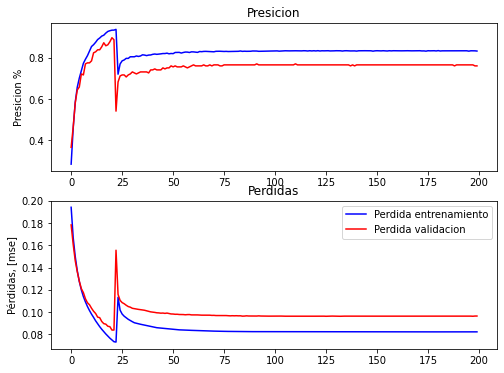

In [30]:
from matplotlib.pyplot import figure

history = best_history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(epochs, accuracy, 'b', label='Presicion Entrenamiento')
ax1.plot(epochs, val_accuracy, 'r', label='Presicion Validacion')
ax1.set_title('Presicion')
ax1.set_ylabel('Presicion %')
# ax1.legend()
# ax1.figure()

ax2.plot(epochs, loss, 'b', label='Perdida entrenamiento')
ax2.plot(epochs, val_loss, 'r', label='Perdida validacion')
ax2.set_title('Perdidas')
ax2.set_ylabel('Pérdidas, [mse]')

plt.legend()
plt.savefig('{}/zybo_{}.png'.format(OUTPUT_FOLDER, DATA_LENGTH))
plt.show()

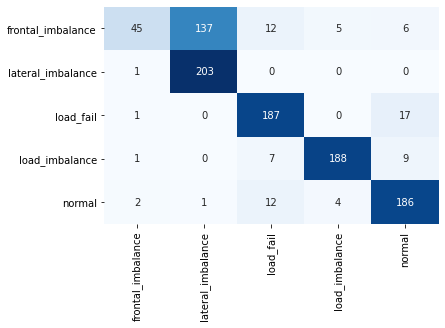

In [7]:
prediction = model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))

import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

matrix = pd.DataFrame(matrix)
plt.figure()
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Blues", cbar = False)
plt.xticks(rotation = 90)
plt.show()

## Conversion a HLS

Se crea el achivo HLS4ml.
https://www.xilinx.com/support/documentation/sw_manuals/xilinx2012_2/ug902-vivado-high-level-synthesis.pdf#page=57

In [11]:
import hls4ml

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

precision = "ap_fixed<16,6>"
resource = 4000

config['Model'] = {}
config['Model']['ReuseFactor'] = resource
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = precision

for Layer in model.layers:
    if isinstance(Layer, tf.keras.layers.Flatten):
        config['LayerName'][Layer.name] = {}
    config['LayerName'][Layer.name]['Precision'] = precision
    config["LayerName"][Layer.name]["ReuseFactor"] = resource
    config["LayerName"][Layer.name]["Strategy"] = 'Resource'


input_data = os.path.join(os.getcwd(), '{}/X_test.npy'.format(OUTPUT_FOLDER))
output_predictions = os.path.join(os.getcwd(), '{}/y_qkeras.npy'.format(OUTPUT_FOLDER))

input_data_tb = "{}/X_test.npy".format(OUTPUT_FOLDER)
output_data_tb = "{}/y_test.npy".format(OUTPUT_FOLDER)

io_type = 'io_parallel'  # io_parallel or io_stream

hls_model = hls4ml.converters.convert_from_keras_model(model=model, backend='VivadoAccelerator', io_type=io_type, board='zybo-z7010', part='xc7z010clg400-1',
                                    hls_config=config, output_dir="{}".format(OUTPUT_FOLDER), input_data_tb=input_data_tb, output_data_tb=output_data_tb)

#hls_model = convert_from_keras_model(model=model, backend='VivadoAccelerator', io_type=io_type, board='zcu102',# part='xc7z010clg400-1',
#                                    hls_config=config, output_dir="{}".format(OUTPUT_FOLDER), input_data_tb=input_data_tb, output_data_tb=output_data_tb)

hls_model.compile()

y_keras = model.predict(test_data)
y_hls = hls_model.predict(test_data)

np.save("{}/y_hls.npy".format(OUTPUT_FOLDER), y_hls)

print("\nAccuracy QKeras: {:.4f}".format(accuracy_score(np.argmax(test_labels, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy HLS4ML: {:.4f}".format(accuracy_score(np.argmax(test_labels, axis=1), np.argmax(y_hls, axis=1))))

score_hls = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(y_hls, axis=1))*100
print("HLS_Score: {}%\n".format(score_hls))

for layer in INTERNAL_LAYERS_SHAPE:
    assert((hls_model.get_weights_data("input_dense_{}".format(layer), "kernel") == qweights["input_dense_{}".format(layer)]["weights"][0]).all())
assert((hls_model.get_weights_data("out_dense", "kernel") == qweights["out_dense"]["weights"][0]).all())

Interpreting Sequential
Topology:
Layer name: input_dense_40_input, layer type: Input
Layer name: input_dense_40, layer type: QDense
Layer name: Relu_40, layer type: QActivation
Layer name: out_dense, layer type: QDense
Layer name: softmax, layer type: QActivation
Interpreting Sequential
Topology:
Layer name: input_dense_40_input, layer type: InputLayer, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: input_dense_40, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 40]
Layer name: Relu_40, layer type: Activation, input shapes: [[None, 40]], output shape: [None, 40]
Layer name: out_dense, layer type: QDense, input shapes: [[None, 40]], output shape: [None, 5]
Layer name: softmax, layer type: Activation, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Writing HLS project
Done

Accuracy QKeras: 0.8066
Accuracy HLS4ML: 0.7588
HLS_Score: 75.87890625%



## Sintesis de Vivado

#### Compilo HLS y armo proyecto vivado

In [ ]:
hls_model.build(csim=False, synth=True, export=True)
hls4ml.report.read_vivado_report('{}/'.format(OUTPUT_FOLDER))

print("Accuracy QKeras: {:.4f}".format(accuracy_score(np.argmax(test_labels, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy HLS4ML: {:.4f}".format(accuracy_score(np.argmax(test_labels, axis=1), np.argmax(y_hls, axis=1))))

#### Genero bitfile para la FPGA
Falta incluir a mano I2C

In [ ]:
hls4ml.templates.VivadoAcceleratorBackend.make_bitfile(hls_model)